In [1]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import yfinance as yf
from datetime import timedelta ,datetime

# Create widgets
dataset_widget = widgets.Text(description="Dataset:")  # Renamed widget to avoid conflict
start_date_widget = widgets.Text(description="Start Date:")
end_date_widget = widgets.Text(description="End Date:")
submit_button = widgets.Button(description="Submit")

# Display widgets
display(dataset_widget, start_date_widget, submit_button)

# Declare df as a global variable
global df


# Define a function to handle input
def handle_submit(b):
    global df  # Use the global df variable
    # Get values from widgets
    dataset = dataset_widget.value
    start_date = start_date_widget.value
    end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

    # Convert start_date and end_date to datetime
    try:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        print(f"Dataset: {dataset}")
        print(f"Start Date: {start_date}")
        print(f"End Date: {end_date}")
        
        # Download data using yfinance
        print("Downloading data...")
        df = yf.download(dataset, start=start_date, end=end_date)
        
        if df.empty:
            print("No data found for the given inputs.")
        else:
            # Convert to DataFrame and save to CSV
            data = pd.DataFrame(df)
            print("Data preview:")
            print(data.head())
            file_name ="Training_Data.csv"
            data.to_csv(file_name)
            print(f"Data saved to {file_name}")
            
            # Read the saved CSV file after saving
            df = pd.read_csv(file_name)
            
            # Drop missing values
            df = df.dropna()
            
            # Display the last 15 rows
            print("Last 15 rows of the dataset:")
            print(df.tail(15))
    except Exception as e:
        print(f"Error: {e}")

# Attach the function to the button click
submit_button.on_click(handle_submit)


Text(value='', description='Dataset:')

Text(value='', description='Start Date:')

Button(description='Submit', style=ButtonStyle())

In [2]:
import pandas as pd

# Define the correct column names
column_names = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Load the CSV file, skipping the first two rows
df = pd.read_csv("Training_Data.csv", skiprows=2)

# Assign the correct column names
df.columns = column_names

# Convert the 'Date' column to datetime format
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Optionally, set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Print the cleaned DataFrame
print("\nCleaned DataFrame:")
print(df.head())



Cleaned DataFrame:
             Adj Close       Close        High         Low        Open  \
Date                                                                     
2021-07-23  126.000000  126.000000  138.899994  115.000000  116.000000   
2021-07-26  140.649994  140.649994  143.750000  125.300003  126.349998   
2021-07-27  132.899994  132.899994  147.800003  127.750000  141.699997   
2021-07-28  131.199997  131.199997  135.000000  123.550003  131.000000   
2021-07-29  141.550003  141.550003  144.000000  132.199997  134.949997   

               Volume  
Date                   
2021-07-23  694895290  
2021-07-26  249723854  
2021-07-27  240341900  
2021-07-28  159793731  
2021-07-29  117973089  


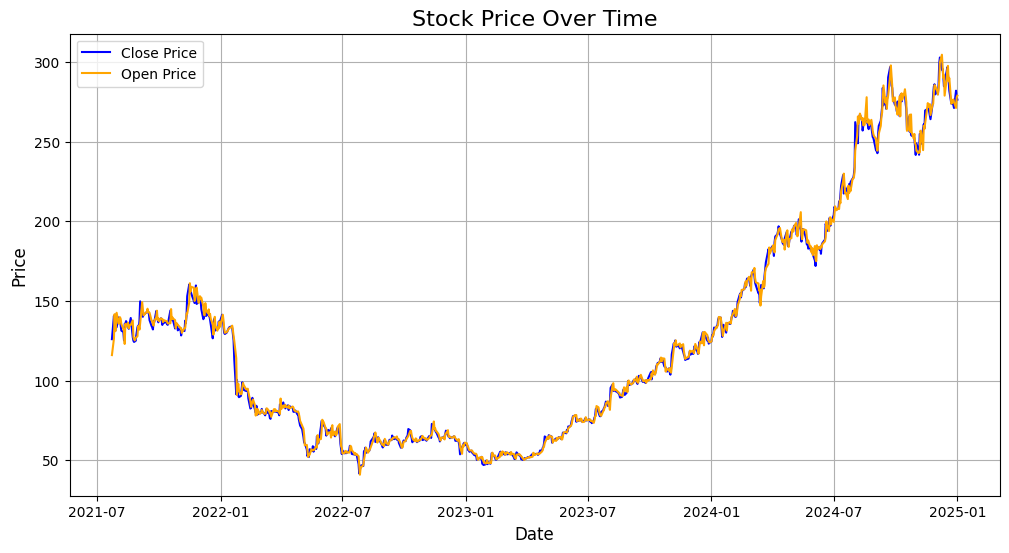

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure numeric values
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')

# Handle missing values
df = df.dropna(subset=['Close', 'Open'])

# Set 'Date' as index if not already done
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
    df.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['Open'], label='Open Price', color='orange')
plt.title('Stock Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

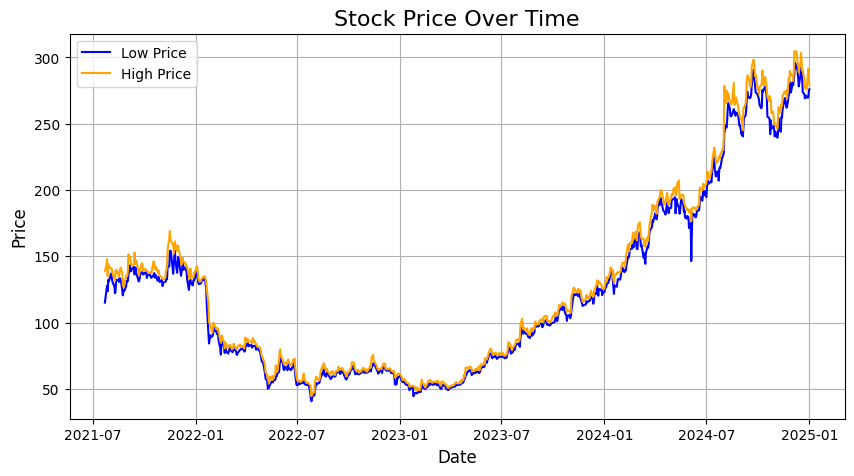

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure numeric values
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')

# Handle missing values
df = df.dropna(subset=['Low', 'High'])

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['Low'], label='Low Price', color='blue')
plt.plot(df['High'], label='High Price', color='orange')
plt.title('Stock Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform initial ADF test
result = adfuller(df['Close'].dropna())
count = 1

print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Check if the data is already stationary
if result[1] <= 0.05:
    print("The data is stationary.")
else:
    while result[1] > 0.05:
        # Apply differencing
        df[f'Close_diff_{count}'] = df['Close'].diff(count)
        
        # Drop missing values and reapply the ADF test
        result = adfuller(df[f'Close_diff_{count}'].dropna())
        
        print(f"ADF Statistic after {count} differencing:", result[0])
        print(f"p-value after {count} differencing:", result[1])
        
        if result[1] <= 0.05:
            print(f"The data is stationary after {count} differencing(s).")
            break
        
        count += 1
        
        # Limit the number of differencing attempts to avoid infinite loops
        if count > 10:
            print("Exceeded maximum differencing attempts. The data might not be stationary.")
            break
    df['Close_diff']=df[f'Close_diff_{count}']

ADF Statistic: 0.6446246333123352
p-value: 0.9886654301871998
ADF Statistic after 1 differencing: -31.30181856523705
p-value after 1 differencing: 0.0
The data is stationary after 1 differencing(s).


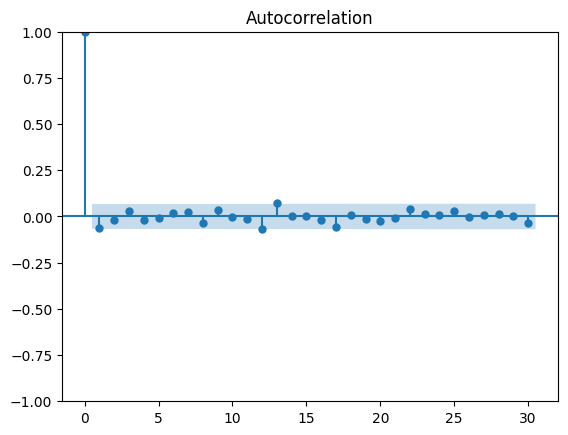

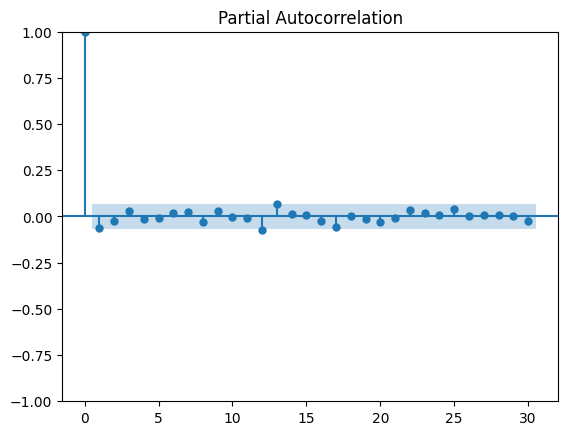

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Close_diff'].dropna(),lags=30)
plot_pacf(df['Close_diff'].dropna(),lags=30)
plt.show()

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ensure 'Close' column is numeric
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# ARIMA model (using some chosen order values)
model = ARIMA(df['Close'], order=(12,1,20))
arima_result = model.fit()

# Define the start and end date (ensure they match the datetime format)
start_date = pd.to_datetime("2024-12-10")
end_date = (datetime.now() - timedelta(days=2)).strftime('%Y-%m-%d')

# Ensure start_date and end_date are within the index range
if start_date not in df.index or end_date not in df.index:
    print("The start_date or end_date is not found in the data's index.")
    print(f"Available dates are: {df.index.min()} to {df.index.max()}")
else:
    # Forecast for the specified range
    predicted_data = arima_result.predict(start=start_date, end=end_date, typ='levels')

    # Add predictions to the DataFrame
    df.loc[start_date:end_date, 'Predicted'] = predicted_data
    print("Last 10 actual 'Close' values:")
    print(df['Close'].tail(10))
    print("\nLast 10 predicted 'Close' values:")
    print(predicted_data.tail(10))

    # Plotting the actual vs predicted values
    plt.figure(figsize=(12, 7))
    plt.plot(df['Close'], label='Actual Close Prices', color='blue')
    plt.plot(df['Predicted'], label='Predicted Close Prices', color='red')
    plt.title('Actual vs Predicted Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()


c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-st

The start_date or end_date is not found in the data's index.
Available dates are: 2021-07-23 00:00:00 to 2025-01-01 00:00:00


In [8]:
#Prediction Accurecy
# # Ensure the column exists
'''if 'predicted_data' not in df.columns:
    raise KeyError("The DataFrame does not contain 'predicted_data'. Check your prediction process.")
'''
# Align actual and predicted values
actual = df['Close'].dropna()
predicted = predicted_data.dropna()

# Align indices to ensure comparison
actual = actual.loc[predicted.index]

# Check alignment
if len(actual) != len(predicted):
    raise ValueError("Actual and predicted values have mismatched indices after alignment.")

# Metrics calculations (MAE, RMSE, R², MAPE, accuracy, directional accuracy)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate errors and accuracy
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predicted)

# Avoid division by zero in MAPE
actual_nonzero = actual.replace(0, np.nan)
mape = np.mean(np.abs((actual_nonzero - predicted) / actual_nonzero)) * 100
accuracy = 100 - mape if not np.isnan(mape) else 0

# Print results
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.4f}')
print(f'Model Accuracy (100 - MAPE): {accuracy:.2f}%')

# Directional accuracy
actual_direction = np.sign(actual.diff().dropna())
predicted_direction = np.sign(predicted.diff().dropna())

# Align indices
actual_direction = actual_direction.loc[predicted_direction.index]

# Check alignment
if len(actual_direction) != len(predicted_direction):
    raise ValueError("Directional values have mismatched indices after alignment.")

directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
print(f'Directional Accuracy: {directional_accuracy:.2f}%')


NameError: name 'predicted_data' is not defined

c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


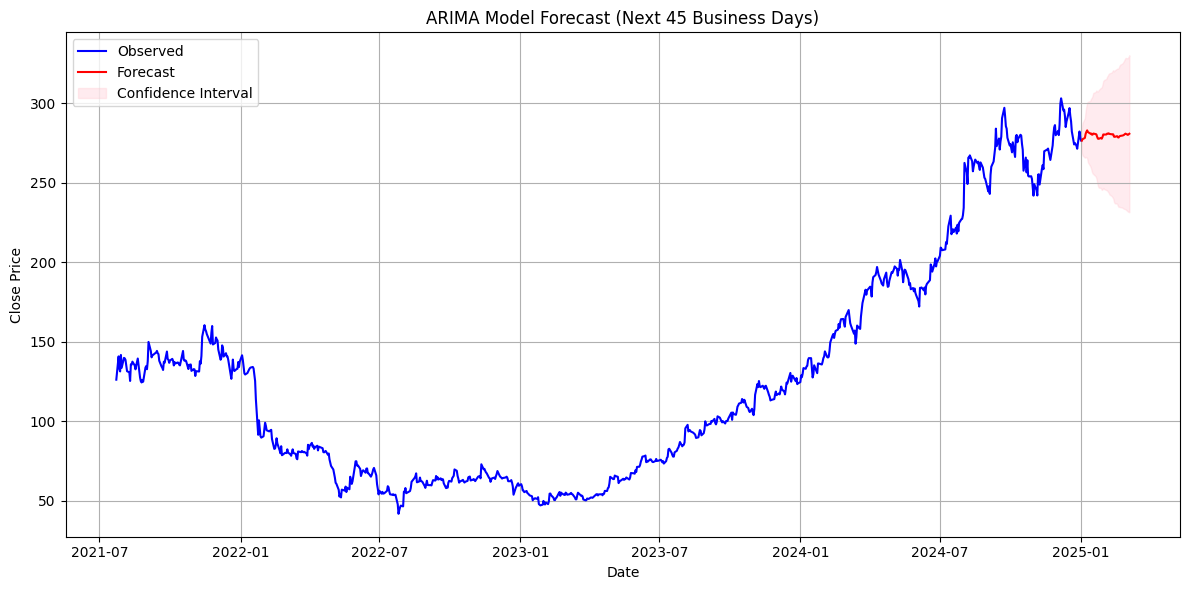

In [9]:
# Forecast the next 45 days
forecast_steps = 45
forecast = arima_result.get_forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

# Extract forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the observed data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],  # Lower bound of the confidence interval
    forecast_ci.iloc[:, 1],  # Upper bound of the confidence interval
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# Customize the plot
plt.title('ARIMA Model Forecast (Next 45 Business Days)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
#Date assigning with forecasted data
import pandas as pd

# Forecast the next 15 business days (or any required period)
forecast_steps = len(forecast_mean)  # Assuming forecast_mean has all the predicted values

# Generate NSE working days starting from the next day after the last index in `df`
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), 
                               periods=forecast_steps, 
                               freq='B')  # 'B' ensures business days only

# Assign dates to forecast_mean
forecast_mean_with_dates = forecast_mean.copy()
forecast_mean_with_dates.index = forecast_dates  # Set the generated dates as the index
forecast_mean_with_dates = forecast_mean_with_dates.to_frame(name='Predicted Close')
forecast_mean_with_dates['Date'] = forecast_mean_with_dates.index

# Reset index to have a separate 'Date' column if required
forecast_mean_with_dates.set_index('Date', inplace=True)

# Print the updated forecast data
print(forecast_mean_with_dates.head(15))


            Predicted Close
Date                       
2025-01-02       276.335341
2025-01-03       277.272091
2025-01-06       278.039959
2025-01-07       280.571156
2025-01-08       281.911520
2025-01-09       282.792741
2025-01-10       281.730850
2025-01-13       280.819082
2025-01-14       280.869043
2025-01-15       280.152674
2025-01-16       280.118266
2025-01-17       280.813981
2025-01-20       280.479504
2025-01-21       280.311613
2025-01-22       278.761809


In [11]:
# Downloading Future Value from yf
import yfinance as yf
import pandas as pd
from datetime import datetime  # For handling dates

# Define the ticker and date range
ticker = 'ZOMATO.NS'
start_date = (datetime.now() - timedelta(days=15)).strftime('%Y-%m-%d') # Get today's date as a string
end_date = datetime.now().strftime('%Y-%m-%d')  # Get today's date as a string

# Download the data
df1 = yf.download(ticker, start=start_date, end=end_date)

# Convert to a DataFrame
data = pd.DataFrame(df1)

# Display the DataFrame
print(data['Close'])
print(forecast_mean_with_dates.head(9))


[*********************100%***********************]  1 of 1 completed

Ticker       ZOMATO.NS
Date                  
2024-12-19  288.500000
2024-12-20  282.100006
2024-12-23  273.950012
2024-12-24  274.850006
2024-12-26  273.200012
2024-12-27  271.250000
2024-12-30  282.100006
2024-12-31  278.049988
2025-01-01  276.500000
2025-01-02  284.600006
            Predicted Close
Date                       
2025-01-02       276.335341
2025-01-03       277.272091
2025-01-06       278.039959
2025-01-07       280.571156
2025-01-08       281.911520
2025-01-09       282.792741
2025-01-10       281.730850
2025-01-13       280.819082
2025-01-14       280.869043


In [12]:
#Direction Accurecy of Forecasting
# Directional accuracy: Sign of the difference
actual_direction = np.sign(actual.diff())  # Sign of changes in actual
predicted_direction = np.sign(predicted.diff())  # Sign of changes in predicted

# Align the indices of both series
common_indices = actual_direction.index.intersection(predicted_direction.index)
actual_direction = actual_direction.loc[common_indices]  # Align actual_direction with common indices
predicted_direction = predicted_direction.loc[common_indices]  # Align predicted_direction with common indices

# Check if lengths match after alignment
if len(actual_direction) != len(predicted_direction):
    raise ValueError("Directional values still have mismatched lengths after alignment.")

# Calculate directional accuracy
directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
print(f'Directional Accuracy: {directional_accuracy:.2f}%')


Directional Accuracy: 56.25%


In [13]:
#Forecasting Accurecy Calculation 
# Ensure actual and predicted are aligned and have matching column names
actual = data['Close'].dropna()  # Remove NaN values from actual
predicted = forecast_mean_with_dates.dropna()  # Remove NaN values from predicted

# Rename the predicted column to match the actual column name (if needed)
predicted = predicted.rename(columns={'Predicted Close': 'Traning_Data'})

# Intersect indices to match actual and predicted
common_indices = actual.index.intersection(predicted.index)
actual = actual.loc[common_indices]  # Align actual with common indices
predicted = predicted.loc[common_indices]  # Align predicted with common indices

# Check if lengths match
if len(actual) != len(predicted):
    raise ValueError("Actual and predicted values have mismatched lengths after alignment.")

# Metrics calculations (MAE, RMSE, R², MAPE, accuracy, directional accuracy)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate errors
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predicted)

# Avoid division by zero in MAPE: Calculate only for non-zero values of actual
non_zero_indices = actual != 0  # Boolean index for non-zero actual values
mape = np.mean(np.abs((actual[non_zero_indices] - predicted[non_zero_indices]) / actual[non_zero_indices])) * 100

# Calculate accuracy
accuracy = 100 - mape if not np.isnan(mape) else 0

# Print errors and accuracy
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.4f}')
print(f'Model Accuracy (100 - MAPE): {accuracy:.2f}%')




Mean Absolute Error (MAE): 8.26
Root Mean Squared Error (RMSE): 8.26
R-squared Score (R²): nan
Model Accuracy (100 - MAPE): 0.00%


c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


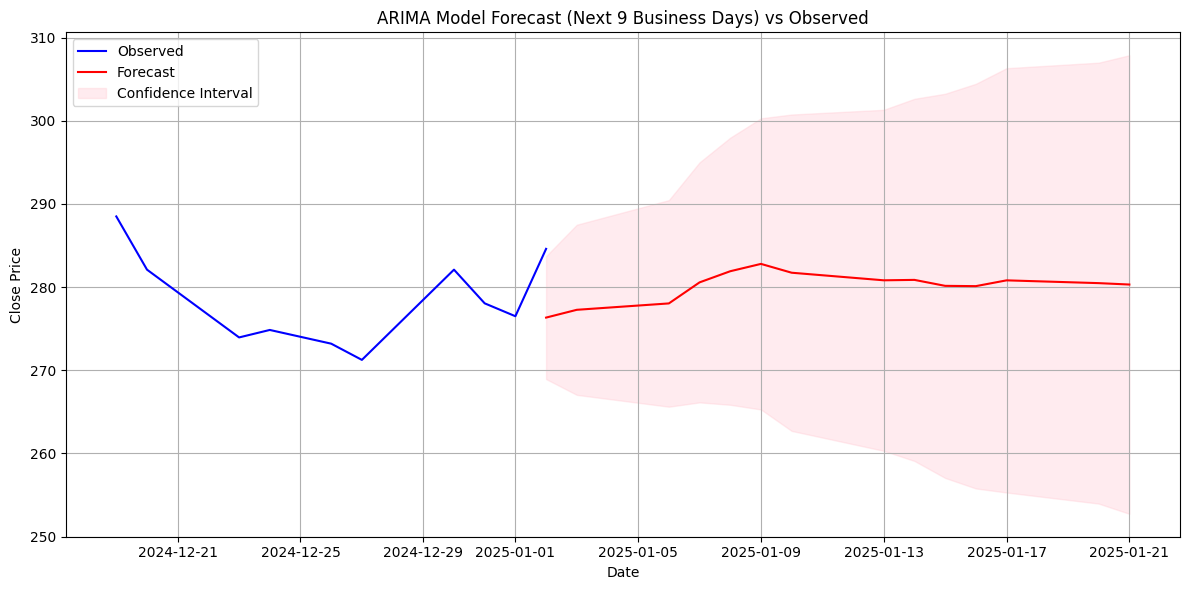

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Forecast the next 9 days (adjust as needed)
forecast_steps = 14
forecast = arima_result.get_forecast(steps=forecast_steps)

# Create a new index for the forecast that follows the last date in the actual data
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

# Extract forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Combine the observed data and forecast data for plotting
combined_index = df.index.append(forecast_index)
combined_data = pd.concat([data['Close'], forecast_mean])

# Plot the observed and forecasted data on the same axis
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'].dropna(), label='Observed', color='blue')  # Actual data
plt.plot(forecast_index, forecast_mean.dropna(), label='Forecast', color='red')  # Forecasted data
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],  # Lower bound of the confidence interval
    forecast_ci.iloc[:, 1],  # Upper bound of the confidence interval
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# Customize the plot
plt.title('ARIMA Model Forecast (Next 9 Business Days) vs Observed')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
